### Importing Necessary Libraries

In [73]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError

In [74]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Importing & Opening the data 

In [75]:
# Load the dataset
netcdf_file_path = "Data/final_SSC_Data.nc"

# Open the data using xarray
dataset = xr.open_dataset(netcdf_file_path)

### Converting Dataframe to Pandas and Dropping uneccessary Columns

In [76]:
# Convert the dataset to a pandas DataFrame
df = dataset.to_dataframe().reset_index()

# Drop columns from the DataFrame
df = df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

df

,time,lat,lon,u,v
0,2020-02-25 15:00:00,35.744701,13.6768,NaN,NaN
1,2020-02-25 15:00:00,35.744701,13.7174,NaN,NaN
2,2020-02-25 15:00:00,35.744701,13.7579,NaN,NaN
3,2020-02-25 15:00:00,35.744701,13.7985,NaN,NaN
4,2020-02-25 15:00:00,35.744701,13.8390,NaN,NaN
...,...,...,...,...,...
60892983,2023-08-01 23:00:00,36.880199,15.2182,NaN,NaN
60892984,2023-08-01 23:00:00,36.880199,15.2587,NaN,NaN
60892985,2023-08-01 23:00:00,36.880199,15.2993,NaN,NaN
60892986,2023-08-01 23:00:00,36.880199,15.3398,NaN,NaN


### Filtering Dataframe by specific pair of coordinates & applying Spline Interpolation to NaNs

In [77]:
# Define target latitude and longitude for data filtering.
target_lat = 36.03409957885742
target_lon = 14.528599739074707

# Filter the DataFrame to only include data for the specified coordinates.
df = df[(df['lat'] == target_lat) & (df['lon'] == target_lon)]

# Ensure the DataFrame is sorted by time
df.sort_index(inplace=True)

# Drop rows where either 'u' or 'v' (or both) have NaN values
df.dropna(subset=['u', 'v'], inplace=True)

df

C:\Users\MarkDingli\AppData\Local\Temp\ipykernel_15676\1160317032.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['u', 'v'], inplace=True)


,time,lat,lon,u,v
580,2020-02-25 15:00:00,36.0341,14.5286,0.142856,-0.085644
2816,2020-02-25 16:00:00,36.0341,14.5286,0.133010,-0.018187
5052,2020-02-25 17:00:00,36.0341,14.5286,0.096112,0.009815
7288,2020-02-25 18:00:00,36.0341,14.5286,0.075022,0.004789
9524,2020-02-25 19:00:00,36.0341,14.5286,0.039128,0.012974
...,...,...,...,...,...
60882388,2023-08-01 19:00:00,36.0341,14.5286,0.140230,-0.185754
60884624,2023-08-01 20:00:00,36.0341,14.5286,0.113880,-0.225836
60886860,2023-08-01 21:00:00,36.0341,14.5286,0.101888,-0.212993
60889096,2023-08-01 22:00:00,36.0341,14.5286,0.108439,-0.201915


### Converting the 'time' column to datetime format & setting it as the index

In [78]:
df[['time', 'u', 'v']]

# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)

# Set the 'time' column as the index of the DataFrame
df.set_index('time')['u']

C:\Users\MarkDingli\AppData\Local\Temp\ipykernel_15676\1220816150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)


time
2020-02-25 15:00:00    0.142856
2020-02-25 16:00:00    0.133010
2020-02-25 17:00:00    0.096112
2020-02-25 18:00:00    0.075022
2020-02-25 19:00:00    0.039128
                         ...   
2023-08-01 19:00:00    0.140230
2023-08-01 20:00:00    0.113880
2023-08-01 21:00:00    0.101888
2023-08-01 22:00:00    0.108439
2023-08-01 23:00:00    0.182186
Name: u, Length: 14282, dtype: float64

### Plotting the 'u' and 'v' 

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

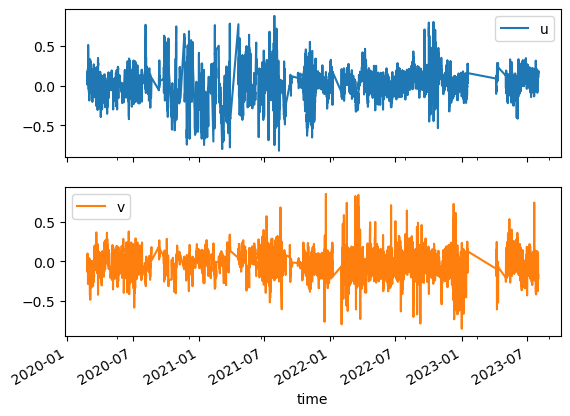

In [79]:
# Plot 'u' and 'v' columns over time
df.set_index('time')[['u', 'v']].plot(subplots=True)

### Preparing the input features

In [80]:
# Select 'u' and 'v' columns as input features
df_input = df[['u', 'v']]
df_input

,u,v
580,0.142856,-0.085644
2816,0.133010,-0.018187
5052,0.096112,0.009815
7288,0.075022,0.004789
9524,0.039128,0.012974
...,...,...
60882388,0.140230,-0.185754
60884624,0.113880,-0.225836
60886860,0.101888,-0.212993
60889096,0.108439,-0.201915


### Saving as features & setting the targets

In [81]:
# Save scaled data as features for model input
features = df_input.to_numpy()

# Set the first column (scaled 'u' values) as the target variable
target = df_input['u'].values   

### Splitting Data in Train & Test splits

In [82]:
# First, split into training (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=False)

# Then, split the temp set into validation and test sets (50% each of 30% => 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, shuffle=False)

# Check the shape of each set
X_train.shape, X_val.shape, X_test.shape

((9997, 2), (2142, 2), (2143, 2))

### Creating batches of time series data 

In [83]:
win_length = 24
batch_size = 32
num_features = 2

train_generator = TimeseriesGenerator(X_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

train_generator[0]

(array([[[ 0.14285568, -0.08564356],
         [ 0.1330104 , -0.01818698],
         [ 0.09611177,  0.00981483],
         ...,
         [ 0.12837919, -0.12367474],
         [ 0.11263009, -0.13562352],
         [ 0.17713719, -0.11734034]],
 
        [[ 0.1330104 , -0.01818698],
         [ 0.09611177,  0.00981483],
         [ 0.0750224 ,  0.00478938],
         ...,
         [ 0.11263009, -0.13562352],
         [ 0.17713719, -0.11734034],
         [ 0.16656526, -0.11790268]],
 
        [[ 0.09611177,  0.00981483],
         [ 0.0750224 ,  0.00478938],
         [ 0.03912837,  0.01297434],
         ...,
         [ 0.17713719, -0.11734034],
         [ 0.16656526, -0.11790268],
         [ 0.17160282, -0.09838213]],
 
        ...,
 
        [[ 0.18406637, -0.01071953],
         [ 0.16976051, -0.04965574],
         [ 0.12827602, -0.11024531],
         ...,
         [ 0.17302216, -0.12531755],
         [ 0.4686562 , -0.07375661],
         [ 0.51020731, -0.0528084 ]],
 
        [[ 0.16976051, -0.049

### Constructing the LSTM Model

In [84]:
# # Define the LSTM model architecture with tanh activation
# model = Sequential([
#     LSTM(128, input_shape=(win_length, num_features), return_sequences=True),
#     LSTM(128, return_sequences=True),
#     Dropout(0.3),
#     LSTM(64),
#     Dropout(0.3),
#     Dense(1, activation='leaky_relu')
# ])

model = Sequential([
    LSTM(256, input_shape=(win_length, num_features), return_sequences=True),
    Dropout(0.3),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


# Display the updated model's architecture
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 24, 256)           265216    
                                                                 
 dropout_19 (Dropout)        (None, 24, 256)           0         
                                                                 
 lstm_18 (LSTM)              (None, 24, 256)           525312    
                                                                 
 dropout_20 (Dropout)        (None, 24, 256)           0         
                                                                 
 lstm_19 (LSTM)              (None, 24, 128)           197120    
                                                                 
 dropout_21 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_20 (LSTM)              (None, 64)               

### Training the Model

In [85]:
# Set up early stopping 
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=8, 
                               mode='min',
                               restore_best_weights=True)

# Compile the model 
model.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.001),
              metrics=[MeanAbsoluteError()])

# Define ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint(filepath="Data/LSTM/Saved_Models/lstm_test_model",
                                   save_best_only=True,
                                   monitor='val_loss',  
                                   mode='min',
                                   verbose=0)  

# Fit the model to
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=val_generator,
                    shuffle=False,
                    callbacks=[early_stopping, model_checkpoint])

# Determine the epoch number at best performance
best_epoch = early_stopping.stopped_epoch - early_stopping.patience

print(f"="*125)
print(f"Training stopped at epoch: {best_epoch + 1}")
print(f"Best validation loss achieved at epoch: {best_epoch + 1}")

Epoch 1/100
312/312 [==============================] - ETA: 0s - loss: 0.0258 - mean_absolute_error: 0.1141INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


312/312 [==============================] - 72s 216ms/step - loss: 0.0258 - mean_absolute_error: 0.1141 - val_loss: 0.0185 - val_mean_absolute_error: 0.0981
Epoch 2/100
312/312 [==============================] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.1042INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


312/312 [==============================] - 146s 469ms/step - loss: 0.0222 - mean_absolute_error: 0.1042 - val_loss: 0.0143 - val_mean_absolute_error: 0.0829
Epoch 3/100
312/312 [==============================] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.0817INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


312/312 [==============================] - 178s 572ms/step - loss: 0.0151 - mean_absolute_error: 0.0817 - val_loss: 0.0086 - val_mean_absolute_error: 0.0578
Epoch 4/100
312/312 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.0680INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


312/312 [==============================] - 181s 579ms/step - loss: 0.0114 - mean_absolute_error: 0.0680 - val_loss: 0.0080 - val_mean_absolute_error: 0.0553
Epoch 5/100
312/312 [==============================] - ETA: 0s - loss: 0.0105 - mean_absolute_error: 0.0642INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


INFO:tensorflow:Assets written to: Data/LSTM/Saved_Models\lstm_test_model\assets


312/312 [==============================] - 187s 600ms/step - loss: 0.0105 - mean_absolute_error: 0.0642 - val_loss: 0.0078 - val_mean_absolute_error: 0.0546
Epoch 6/100
312/312 [==============================] - 173s 554ms/step - loss: 0.0104 - mean_absolute_error: 0.0635 - val_loss: 0.0080 - val_mean_absolute_error: 0.0548
Epoch 7/100
312/312 [==============================] - 145s 463ms/step - loss: 0.0104 - mean_absolute_error: 0.0630 - val_loss: 0.0083 - val_mean_absolute_error: 0.0574
Epoch 8/100
312/312 [==============================] - 146s 467ms/step - loss: 0.0105 - mean_absolute_error: 0.0634 - val_loss: 0.0080 - val_mean_absolute_error: 0.0557
Epoch 9/100
312/312 [==============================] - 148s 476ms/step - loss: 0.0104 - mean_absolute_error: 0.0626 - val_loss: 0.0078 - val_mean_absolute_error: 0.0540
Epoch 10/100
312/312 [==============================] - 149s 478ms/step - loss: 0.0103 - mean_absolute_error: 0.0624 - val_loss: 0.0083 - val_mean_absolute_error: 0.05

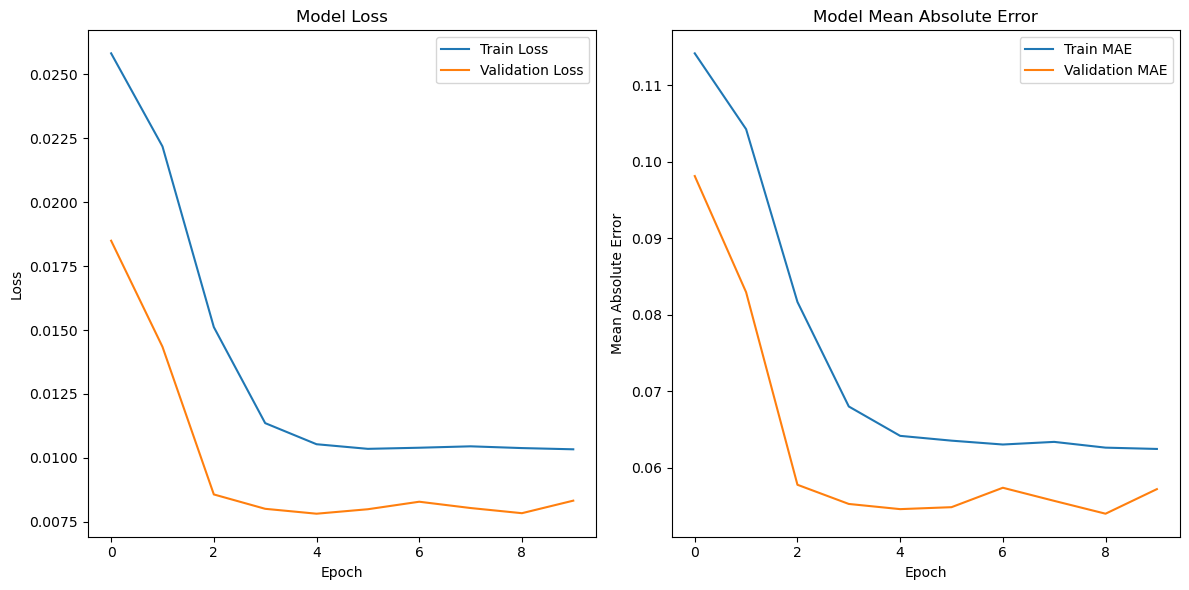

In [86]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

### Making predictions & evaluating from the Test set

In [87]:
# Generate predictions for the test data
predictions = model.predict(test_generator)

67/67 [==============================] - 6s 81ms/step


### Preparing the final DataFrame for plotting and analysis

In [88]:
df_final = df_input.iloc[-len(predictions):].copy()

df_final['u_pred'] = predictions.flatten()

df_final

,u,v,u_pred
55934120,0.194452,-0.142318,0.119125
55936356,0.172573,-0.401714,0.133308
55938592,0.229591,-0.090801,0.118220
55940828,0.225758,-0.085512,0.139577
55943064,0.200248,-0.117243,0.144877
...,...,...,...
60882388,0.140230,-0.185754,0.097605
60884624,0.113880,-0.225836,0.096364
60886860,0.101888,-0.212993,0.082178
60889096,0.108439,-0.201915,0.073848


In [89]:
# Actual and predicted 'u' values
y_true = df_final['u'].values
y_pred = df_final['u_pred'].values

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Print out the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 0.0034195741012368924
Mean Absolute Error (MAE): 0.04521151468530328
Root Mean Squared Error (RMSE): 0.058477124597887786


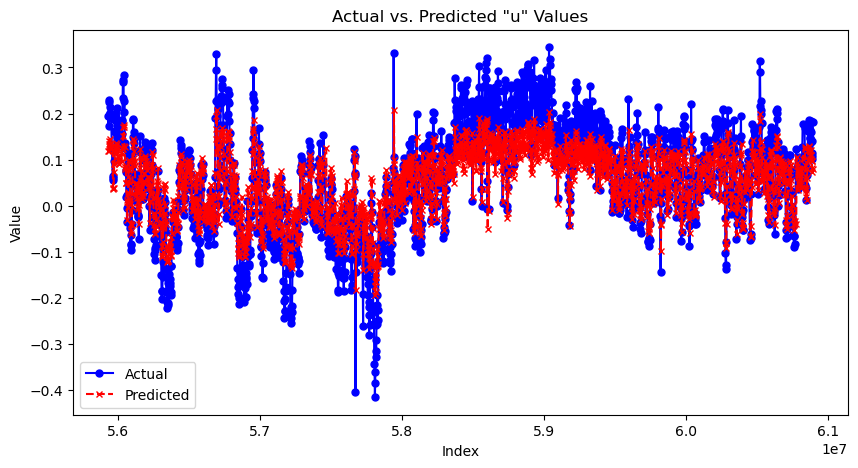

In [90]:
plt.figure(figsize=(10, 5))  
plt.plot(df_final.index, df_final['u'], label='Actual', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(df_final.index, df_final['u_pred'], label='Predicted', color='red', marker='x', linestyle='--', markersize=5)
plt.title('Actual vs. Predicted "u" Values')  
plt.xlabel('Index') 
plt.ylabel('Value')  
plt.legend() 
plt.show() 

### Making a real life Rolling Prediction

In [94]:
# Path to the NetCDF file containing input data for August 1, 2023
input_data_path = "Data/1_day_input_SSC_Data.nc"

# Load the dataset
input_dataset = xr.open_dataset(input_data_path)

# Select data for the target latitude and longitude
input_data = input_dataset.sel(lat=target_lat, lon=target_lon, method='nearest').to_dataframe().reset_index()

# Ensure the DataFrame is sorted by time (if not already)
input_data.sort_values('time', inplace=True)

# Remove NaN values from the DataFrame
input_data.dropna(inplace=True)

# Select and preprocess the required features (assuming 'u' and 'v' are the features)
features = input_data[['u', 'v']].values

features

array([[ 0.04413579, -0.31401586],
       [ 0.06336146, -0.06410138],
       [ 0.03926946, -0.09939741],
       [ 0.01148871, -0.07444684],
       [ 0.06687024, -0.02658429],
       [ 0.08245937,  0.01590032],
       [ 0.11526113,  0.08625146],
       [ 0.11226195, -0.02134833],
       [ 0.16147913, -0.0088526 ],
       [ 0.16201285, -0.05997727],
       [ 0.18552091, -0.03896902],
       [ 0.18162401, -0.05580212],
       [ 0.16830322, -0.10497808],
       [ 0.16340559, -0.09979095],
       [ 0.14768876, -0.0658256 ],
       [ 0.14783038, -0.13405441],
       [ 0.18293552, -0.16994417],
       [ 0.15929471, -0.10127216],
       [ 0.1389972 , -0.16640885],
       [ 0.14023004, -0.18575354],
       [ 0.11388001, -0.22583594],
       [ 0.10188809, -0.21299313],
       [ 0.10843891, -0.20191476],
       [ 0.18218557, -0.184015  ]])

In [ ]:
# Reshape data to match the input shape expected by the LSTM model
last_24_hours_features = features.reshape(1, win_length, num_features)

# Initialize the array to store predictions
predictions_u = []

# Make predictions for each hour
for i in range(24):  # Assuming you want to predict 24 hours ahead
    # Predict the next step
    current_prediction_u = model.predict(last_24_hours_features, verbose=0)[0, 0]
    
    # Append the prediction to the predictions list
    predictions_u.append(current_prediction_u)
    
    # Update the last 24 hours for the next prediction
    # Here, only 'u' is updated based on the model's prediction; 'v' remains constant
    new_features = np.concatenate((last_24_hours_features[0, 1:, 0].reshape(-1, 1), np.full((win_length-1, 1), constant_v)), axis=1)
    new_features = np.append(new_features, [[current_prediction_u, constant_v]], axis=0)
    last_24_hours_features = new_features.reshape(1, win_length, num_features)

# Convert predictions to an array for further use
predictions_u = np.array(predictions_u)

In [95]:
# Load the actual data equivalent to the next day (August 2nd, 2023)
actual_data_nc = xr.open_dataset('Data/1_day_actual_SSC_Data.nc')

# Convert to DataFrame and filter based on selected latitude and longitude
actual_data_df = actual_data_nc.sel(lat=target_lat, lon=target_lon, method='nearest').to_dataframe().reset_index()

# Ensure the DataFrame is sorted by time
actual_data_df.sort_values('time', inplace=True) 

# Clean up the DataFrame by dropping unnecessary columns
actual_data_df = actual_data_df.drop(columns=['stdu', 'stdv', 'cov', 'velo', 'head'])

# Remove NaN values from the DataFrame
actual_data_df.dropna(inplace=True)

# Extract 'u' values from the actual data
actual_u_values = actual_data_df['u'].values

# Ensure that the actual data and predictions have the same length
trimmed_predictions_u = predictions_u[:len(actual_u_values)]

# Calculate evaluation metrics using the trimmed predictions
mae = mean_absolute_error(actual_u_values, trimmed_predictions_u)
mse = mean_squared_error(actual_u_values, trimmed_predictions_u)
rmse = np.sqrt(mse)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Create a DataFrame to store actual and predicted values for comparison
comparison_df = pd.DataFrame({
    'Time': actual_data_df['time'],
    'Actual_u': actual_u_values,
    'Predicted_u': trimmed_predictions_u
})

# Display the DataFrame for review
comparison_df

Mean Absolute Error (MAE): 0.0686407871667694
Mean Squared Error (MSE): 0.006759358827775763
Root Mean Squared Error (RMSE): 0.08221531990922229


,Time,Actual_u,Predicted_u
0,2023-08-02 00:00:00,0.158887,0.143332
1,2023-08-02 01:00:00,0.185663,0.118235
2,2023-08-02 02:00:00,0.207159,0.095034
3,2023-08-02 03:00:00,0.153599,0.077167
4,2023-08-02 04:00:00,0.085862,0.063793
5,2023-08-02 05:00:00,0.064690,0.054113
6,2023-08-02 06:00:00,0.079435,0.046651
8,2023-08-02 08:00:00,0.078251,0.041875
9,2023-08-02 09:00:00,0.096126,0.039392
10,2023-08-02 10:00:00,0.128039,0.038541
